In [1]:
import torch
from torch.utils import data
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from diffusion import GaussianDiffusion, Trainer
from unet import UNet

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 16

## Dataloader

In [2]:
import os
import random

class Dataset(data.Dataset):
    def __init__(self, folder, image_size, mode):
        super().__init__()
        self.folder = folder
        image_size = image_size
        self.mode = mode
        # self.data_files = [self.folder +"test/"+ f for f in os.listdir(self.folder+"test/") if os.path.isfile(os.path.join(self.folder+"test/", f))]
        self.data_files = [self.folder +"data/"+ f for f in os.listdir(self.folder+"data/") if os.path.isfile(os.path.join(self.folder+"data/", f))]


        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.Grayscale(num_output_channels=1),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
        ])

        
    def __len__(self):
        # dir_path = self.folder+"test/"
        dir_path = self.folder+"data/"
        res = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])
        return res
    
    def irregular_mask(self, data, rate=0.5):
        """the mask matrix of random sampling
        Args:
            data: original data patches
            rate: sampling rate,range(0,1)
        """
        n = data.size()[-1]
        mask = torch.torch.zeros(data.size(),dtype=torch.float64)
        
        v = round(n*rate)
        TM = random.sample(range(n),v)
        mask[:,:,TM]=1 # missing by column 
        mask = mask.type(torch.HalfTensor)
        return  mask

    def __getitem__(self, index):
        # data = self.folder+"data/"+str(index)+".png"
        data = self.data_files[index]
        img_data = Image.open(data)

        if self.mode == "demultiple":

            return self.transform(img_data)
        elif self.mode == "interpolation":
            return self.irregular_mask(self.transform(img_data)), self.transform(img_data)
        elif self.mode == "denoising":
            img = self.transform(img_data)
            mean = torch.mean(img)
            std = torch.std(img)
            noise = 0.5*torch.normal(mean, std, size =(img.shape[0], img.shape[1], img.shape[2]))
            img_ = img + noise
            
            return img
        

        else:
            print("ERROR MODE")

## Create Model

In [3]:
mode = "demultiple" #demultiple, interpolation, denoising
folder = './dataset/'+mode+'/data_train/'

# model = UNet(
#         in_channel=2,
#         out_channel=1
# ).cuda()

image_size = (128, 128)
# diffusion = GaussianDiffusion(
#     model,
#     mode = mode,
#     channels = 1,
#     image_size = image_size,
#     timesteps = 2000,
#     loss_type = 'l1', # L1 or L2
# ).cuda()
diffusion = torch.load("/csim2/zhangzhiyu/MyProjects/Seismology/diffseis/results_demultiple/model-900.pt")
ds = Dataset(folder, image_size=image_size, mode=mode)

/tmp/ipykernel_2817322/1409397791.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  diffusion = torch.load("/csim2/zhangzhiyu/MyProjects/Seismology/diffseis/results_demul

## Load Model

In [4]:
num = 4
in_samples = np.zeros([num,image_size[0],image_size[1]])
out_samples = np.zeros([num,image_size[0],image_size[1]])

for i, x_in in enumerate(ds):
    x_start = x_in[0]
    # x_start = torch.stack((x_start, x_start), dim=0)
    x_start = torch.unsqueeze(x_start, dim=0)
    x_start = torch.unsqueeze(x_start, dim=0)
    print(x_start.shape)
    # x_ = x_in[1]
    # x_ = torch.unsqueeze(x_, dim=0)


    out = diffusion.inference(x_in=x_start.cuda())

    in_samples[i] = out[0,0].cpu().detach().numpy()
    out_samples[i] = out[1,0].cpu().detach().numpy()
    if mode == "interpolation":
        out_samples[i] = out[2,0].cpu().detach().numpy()
    if i == num-1:
        break

torch.Size([1, 1, 128, 128])


sampling loop time step: 100%|██████████| 2000/2000 [00:18<00:00, 110.01it/s]


torch.Size([1, 1, 128, 128])


sampling loop time step: 100%|██████████| 2000/2000 [00:13<00:00, 152.26it/s]


torch.Size([1, 1, 128, 128])


sampling loop time step: 100%|██████████| 2000/2000 [00:16<00:00, 118.03it/s]


torch.Size([1, 1, 128, 128])


sampling loop time step: 100%|██████████| 2000/2000 [00:15<00:00, 126.25it/s]


## Plotting

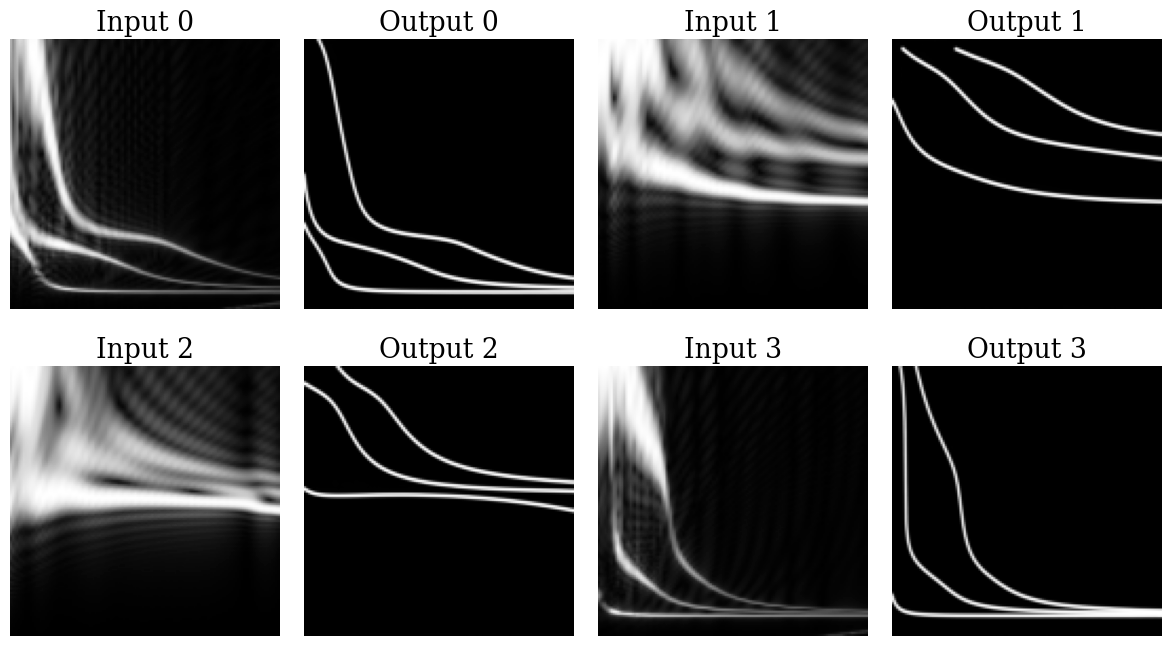

In [5]:
num = 10

fig, axs = plt.subplots(2, 4, figsize=(12,7))
# axs = axs.ravel()
axs = axs.flatten()

# max_ = x_start.max()
# min_ = x_start.min()
cont = 0
for i in range(4):
    axs[cont].imshow(in_samples[i], cmap="Greys_r")
    axs[cont].set_title("Input "+str(i))
    cont = cont+1
    axs[cont].imshow(out_samples[i], cmap="Greys_r")
    axs[cont].set_title("Output "+str(i))
    cont = cont+1
[axi.set_axis_off() for axi in axs.ravel()]
fig.tight_layout()

In [61]:
# %matplotlib inline
import sys
import numpy as np
import matplotlib.pyplot as plt
import pylops
from PIL import Image

from functools import partial
from scipy.optimize import minimize, Bounds
from disba import PhaseDispersion

sys.path.append('../')

from Dispersion.surfacewaves import *
from Dispersion.dispersionspectra import *
from Dispersion.inversion import *

import ccfj
import scipy
from Dispersion.Dispersion.dispersion import get_dispersion


def get_cpr(thick, vs, period):
    
    true_model = np.vstack([thick, vs*4, vs, np.ones_like(vs)]).T

    # Rayleigh-wave fundamental model dispersion curve 
    pd = PhaseDispersion(*true_model.T)
    cpr = [pd(period, mode=imode, wave="rayleigh") for imode in range(3)]

    return cpr

def random_thick_vs(thick, vs, period, fluctuation_percentage=0.1):
    # 生成浮动值
    random_thick = thick * (1 + fluctuation_percentage * (2 * np.random.rand(len(thick)) - 1))
    random_vs = vs * (1 + fluctuation_percentage * (2 * np.random.rand(len(vs)) - 1))

    try:
        cpr = get_cpr(random_thick, random_vs, period)
        # plt.plot(1/cpr[0][0], cpr[0][1], 'k', lw=2, label='Original')
        return cpr
    except Exception as e:
        print(e)

def get_dshift(nt, dt, nx, dx, nfft, cpr):
    t, x = np.arange(nt)*dt, np.arange(nx)*dx

    # Wavelet
    wav = ormsby(t[:nt//2+1], f=[2, 4, 38, 40], taper=np.hanning)[0][:-1]
    wav = np.roll(np.fft.ifftshift(wav), 20) # apply small shift to make it causal

    # Data
    dshifts, fs, vfs = [], [], []
    for imode in range(3):
        dshift_, f_, vf_ = surfacewavedata(nt, dt, nx, dx, nfft, 
                                        np.flipud(1/cpr[imode][0]), np.flipud(cpr[imode][1]), wav)
        dshifts.append(1./(imode+1)**0.8 * dshift_[np.newaxis])
        fs.append(f_)
        vfs.append(vf_)
    dshift = np.concatenate(dshifts).sum(0)
    return dshift

def park(dshift, dx, dt, cmin, cmax, dc, fmin, fmax):
    f1, c1, img, U, t = get_dispersion(dshift.T, dx, dt, 
                                        cmin, cmax, dc, fmin, fmax)

    return f1, c1, img, U, t

def fj(dshift, dx, dt, cmin, cmax):
    nx, nt = dshift.shape
    x = np.arange(nx)*dx
    f = scipy.fftpack.fftfreq(nt,dt)[:nt//2]
    c = np.linspace(cmin, cmax, 1000)

    out = ccfj.fj_earthquake(dshift,x,c,f,fstride=1,itype=0,func=0)
    
    return f, c, out

def show_fj(f, c, out, fmin, fmax, ii, aa):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.axis("off")
    ax.imshow(out, aspect='auto', cmap='gray',
            extent=(f.min(), f.max(),c.min(), c.max()),origin='lower')

    ax.margins(0)
    ax.set_xlim(fmin, fmax)
    ax.set_ylim(c.min(), c.max())
    # fig.savefig(f'/home/lty/MyProjects/Seismology/diffseis/dataset/demultiple/data_train/data/{aa}{ii:03d}.png', 
    #             dpi=300,bbox_inches='tight', pad_inches=0)
    plt.close()

def show_label(f, c, out, cpr, fmin, fmax, ii, aa):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.axis("off")
    ax.imshow(np.zeros_like(out), aspect='auto', cmap='gray',
            extent=(f.min(), f.max(),c.min(), c.max()),origin='lower')
    for imode in range(3):
        ax.plot(np.flipud(1/cpr[imode][0]), 1.e3*np.flipud(cpr[imode][1]), 
                    'white', lw=4)

    ax.margins(0)
    ax.set_xlim(fmin, fmax)
    ax.set_ylim(c.min(), c.max())

    # fig.savefig(f'/home/lty/MyProjects/Seismology/diffseis/dataset/demultiple/data_train/labels/{aa}{ii:03d}.png', 
    #             dpi=300,bbox_inches='tight', pad_inches=0)
    plt.close()


def save_image(image_numpy, image_path, aspect_ratio=1.0):
    """Save a numpy image to the disk

    Parameters:
        image_numpy (numpy array) -- input numpy array
        image_path (str)          -- the path of the image
    """

    image_pil = Image.fromarray(image_numpy)
    h, w, _ = image_numpy.shape

    if aspect_ratio is None:
        pass
    elif aspect_ratio > 1.0:
        image_pil = image_pil.resize((h, int(w * aspect_ratio)), Image.BICUBIC)
    elif aspect_ratio < 1.0:
        image_pil = image_pil.resize((int(h / aspect_ratio), w), Image.BICUBIC)
    image_pil.save(image_path)


def showOutput(out, cpr, f, c, fmin, fmax):
    from scipy.ndimage import zoom

    x_start = zoom(out, (128/out.shape[0], 128/out.shape[1]))

    x_start = torch.unsqueeze(torch.tensor(x_start), dim=0)
    x_start = torch.unsqueeze(x_start, dim=0)

    out1 = diffusion.inference(x_in=x_start.cuda())

    in_samples = out1[0,0].cpu().detach().numpy()
    out_samples = out1[1,0].cpu().detach().numpy()
    print(out_samples.shape)


    fig, axes = plt.subplots(1, 3, figsize=(12, 6))

    axes[0].imshow(out, aspect='auto', cmap='jet',
        extent=(f.min(), f.max(),c.min(), c.max()),origin='lower')
    axes[0].set_xlim(fmin, fmax)
    axes[0].set_ylim(c.min(), c.max())


    axes[1].imshow(np.zeros_like(out), aspect='auto', cmap='gray',
        extent=(f.min(), f.max(),c.min(), c.max()),origin='lower')
    for imode in range(3):
        axes[1].plot(np.flipud(1/cpr[imode][0]), 1.e3*np.flipud(cpr[imode][1]), 
                    'white', lw=4)
    axes[1].set_xlim(fmin, fmax)
    axes[1].set_ylim(c.min(), c.max())

    axes[2].imshow(out_samples, cmap="Greys_r", aspect='auto', extent=(f.min(), f.max(),c.min(), c.max()))
    # axes[2].set_title("Input "+str(i))
    # axes[2].set_xlim(fmin, fmax)
    # axes[2].set_ylim(c.min(), c.max())





sampling loop time step: 100%|██████████| 2000/2000 [00:16<00:00, 119.21it/s]


(128, 128)


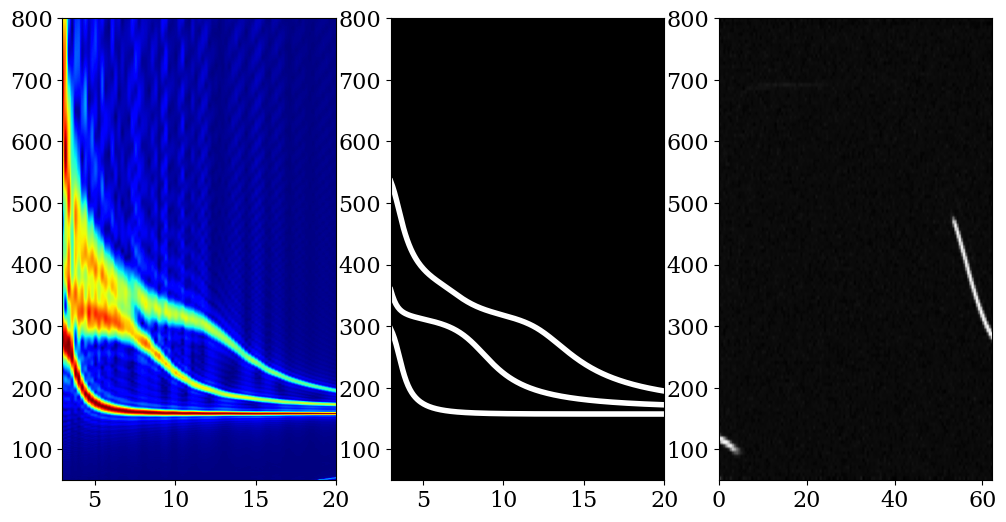

In [63]:
import numpy as np
import random
import concurrent.futures


# Frequency axis
fdisp = np.linspace(3, 20, 301)
period = np.flipud(1/fdisp)         # Periods (must be sorted starting with low periods)

# Axes
nt = 600 # number of time samples
dt = 0.008 # time sampling in s
nx = 201 # number of spatial samples
dx = 2 # spatial sampling in m
nfft = 2**10

dc = 1.
cmin, cmax = 50., 800.
fmin, fmax = fdisp.min(), fdisp.max()


# 原始数组
# thick = np.array([0.01, 0.02, 0.03, 0.01])
# vs = np.array([0.2, 0.4, 0.6, 0.8])
fluctuation_percentage = 0.2        # 定义浮动范围百分比




h1 = np.random.uniform(0.01, 0.1)
h2 = np.random.uniform(0.01, 0.1)
h3 = np.random.uniform(0.01, 0.1)
h4 = np.random.uniform(0.01, 0.1)
v1 = np.random.uniform(0.1, 0.9)
v2 = np.random.uniform(0.1, 0.9)
v3 = np.random.uniform(0.1, 0.9)
v4 = np.random.uniform(0.1, 0.9)

thick = np.array([h1, h2, h3, h4])
vs = np.array([v1, v2, v3, v4])

try:
    cpr = random_thick_vs(thick, vs, period, fluctuation_percentage)
    dshift = get_dshift(nt, dt, nx, dx, nfft, cpr)
    f, c, out = fj(dshift, dx, dt, cmin, cmax)

    showOutput(out, cpr, f, c, fmin, fmax)
    
except Exception as e:
    print(e)





In [ ]:
import numpy as np
import random
import concurrent.futures


# Frequency axis
fdisp = np.linspace(3, 20, 301)
period = np.flipud(1/fdisp)         # Periods (must be sorted starting with low periods)

# Axes
nt = 600 # number of time samples
dt = 0.008 # time sampling in s
nx = 201 # number of spatial samples
dx = 2 # spatial sampling in m
nfft = 2**10

dc = 1.
cmin, cmax = 50., 800.
fmin, fmax = fdisp.min(), fdisp.max()


# 原始数组
# thick = np.array([0.01, 0.02, 0.03, 0.01])
# vs = np.array([0.2, 0.4, 0.6, 0.8])
fluctuation_percentage = 0.2        # 定义浮动范围百分比




h1 = np.random.uniform(0.01, 0.1)
h2 = np.random.uniform(0.01, 0.1)
h3 = np.random.uniform(0.01, 0.1)
h4 = np.random.uniform(0.01, 0.1)
v1 = np.random.uniform(0.1, 0.9)
v2 = np.random.uniform(0.1, 0.9)
v3 = np.random.uniform(0.1, 0.9)
v4 = np.random.uniform(0.1, 0.9)

thick = np.array([h1, h2, h3, h4])
vs = np.array([v1, v2, v3, v4])

cpr = random_thick_vs(thick, vs, period, fluctuation_percentage)
dshift = get_dshift(nt, dt, nx, dx, nfft, cpr)
f, c, out = fj(dshift, dx, dt, cmin, cmax)

from scipy.ndimage import zoom

x_start = zoom(out, (128/out.shape[0], 128/out.shape[1]))

x_start = torch.unsqueeze(torch.tensor(x_start), dim=0)
x_start = torch.unsqueeze(x_start, dim=0)

out1 = diffusion.inference(x_in=x_start.cuda())

in_samples = out1[0,0].cpu().detach().numpy()
out_samples = out1[1,0].cpu().detach().numpy()
print(out_samples.shape)


fig, axes = plt.subplots(1, 3, figsize=(12, 6))

axes[0].imshow(out, aspect='auto', cmap='jet',
    extent=(f.min(), f.max(),c.min(), c.max()),origin='lower')
axes[0].set_xlim(fmin, fmax)
axes[0].set_ylim(c.min(), c.max())


axes[1].imshow(np.zeros_like(out), aspect='auto', cmap='gray',
    extent=(f.min(), f.max(),c.min(), c.max()),origin='lower')
for imode in range(3):
    axes[1].plot(np.flipud(1/cpr[imode][0]), 1.e3*np.flipud(cpr[imode][1]), 
                'white', lw=4)
axes[1].set_xlim(fmin, fmax)
axes[1].set_ylim(c.min(), c.max())

axes[2].imshow(out_samples, cmap="Greys_r", aspect='auto', extent=(f.min(), f.max(),c.min(), c.max()))
# axes[2].set_title("Input "+str(i))
# axes[2].set_xlim(fmin, fmax)
# axes[2].set_ylim(c.min(), c.max())



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 示例数据
data = {
    'Category': ['A', 'B', 'C', 'D'],
    'SNR': [
        [10, 11, 9, 12, 13, 10, 11],
        [8, 9, 10, 8, 7, 8, 9],
        [11, 12, 11, 10, 9, 11, 10],
        [9, 10, 11, 9, 10, 10, 11]
    ]
}

# 转换数据格式
df = pd.DataFrame({
    'Category': sum([[c]*len(s) for c, s in zip(data['Category'], data['SNR'])], []),
    'SNR': sum(data['SNR'], [])
})

# 绘制小提琴图
plt.figure(figsize=(8, 6))
sns.violinplot(x='Category', y='SNR', data=df)
plt.title('SNR')
plt.show()


In [ ]:
df
